In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)

Warning message:
"package 'DESeq2' was built under R version 4.2.2"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
"package 'BiocGenerics' was built under R version 4.2.1"

Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    exp

In [2]:
library(ComplexUpset)

Warning message:
"package 'ComplexUpset' was built under R version 4.2.2"


In [3]:
library(ggrepel)

Warning message:
"package 'ggrepel' was built under R version 4.2.1"


In [4]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [5]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'MED4_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

Warning message in left_join(hgenes, hpath_df, by = "protein_id"):
"Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [6]:
hpath_df_to_export = hpath_df %>% 
     group_by(gene_id) %>% 
     mutate(
         main = paste0(unique(main), collapse = ";"),
         sub = paste0(unique(sub), collapse = ";"),
         path = paste0(unique(path), collapse = ";"),
         ecpath = paste0(unique(ecpath), collapse = ";")
     ) %>%
    ungroup() %>%
    distinct(gene_id, .keep_all = TRUE)

# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

In [7]:
rnaseq_dpath = file.path('..', 'RNASEQ', 'DE_results')
list.files(rnaseq_dpath)


[1] "HOT1A3_DE_DESEQ_results.csv"                
 [2] "HOT1A3_DE_DESEQ_results_ref_vs_long.csv"    
 [3] "HOT1A3_DE_DESEQ_vsd.csv"                    
 [4] "HOT1A3_DE_genes_DESEQ_ref_vs_long_wKEGG.csv"
 [5] "HOT1A3_GOSEQ_results_ref_vs_long.csv"       
 [6] "MED4_DE_DESEQ_results.csv"                  
 [7] "MED4_DE_DESEQ_results_ref_vs_long.csv"      
 [8] "MED4_DE_DESEQ_vsd.csv"                      
 [9] "MED4_DE_genes_DESEQ_wKEGG_ref_vs_long.csv"  
[10] "MED4_GOSEQ_results_ref_vs_long.csv"

In [8]:
proteome_dpath = file.path('..', 'Proteome', 'data')
list.files(proteome_dpath)


[1] "A_axenic_proteome.txt"                                                                          
 [2] "A_axenic_proteome_norm.txt"                                                                     
 [3] "ALT_Axenic_DE.csv"                                                                              
 [4] "ALT_CC_DE.csv"                                                                                  
 [5] "C_ALT_proteome.txt"                                                                             
 [6] "C_ALT_proteome_norm.txt"                                                                        
 [7] "C_PRO_proteome.txt"                                                                             
 [8] "C_PRO_proteome_norm.txt"                                                                        
 [9] "Nov22_Processing.xlsx"                                                                          
[10] "P_axenic_proteome.txt"                                                                          
[11] "P_axenic_proteome_norm.txt"                                                                     
[12] "PRO_Axenic_DE.csv"                                                                              
[13] "PRO_CC_DE.csv"                                                                                  
[14] "uniprot-compressed_true_download_true_fields_accession_2Cid_2Cprotei-2023.01.11-12.43.22.99.txt"

In [9]:
df_rnaseq1 = read.csv(file.path(rnaseq_dpath,'MED4_DE_DESEQ_results_ref_vs_long.csv'))  %>% 
   mutate(gene_id = str_replace(gene_id, '\\.\\.\\.\\d+', '')) 

df_rnaseq2 = read.csv(file.path(rnaseq_dpath,'MED4_DE_DESEQ_results.csv')) %>% 
   mutate(gene_id = str_replace(gene_id, '\\.\\.\\.\\d+', '')) 

In [10]:
unique(df_rnaseq2$contrast)

[1] "Intercept"             "groupandtime_P2_vs_P1" "groupandtime_C1_vs_P1"
[4] "groupandtime_C2_vs_P1" "groupandtime_C3_vs_P1" "groupandtime_C4_vs_P1"
[7] "groupandtime_C5_vs_P1"

In [11]:
df_prot1 = read.csv(file.path(proteome_dpath,'PRO_CC_DE.csv'))
df_prot2 = read.csv(file.path(proteome_dpath,'PRO_Axenic_DE.csv'))

In [12]:
names(df_rnaseq1)
names(df_rnaseq2)
names(df_prot1)
names(df_prot2)



[1] "gene_id"        "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue"         "padj"           "contrast"      
 [9] "na_pvalue"      "na_padj"        "significant"    "direction"     
[13] "status"

[1] "gene_id"        "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue"         "padj"           "contrast"      
 [9] "na_pvalue"      "na_padj"        "significant"    "direction"     
[13] "status"

[1] "X.1"           "logFC"         "AveExpr"       "t"            
 [5] "P.Value"       "adj.P.Val"     "B"             "gene"         
 [9] "count"         "sca.t"         "sca.P.Value"   "sca.adj.pval" 
[13] "contrast"      "gene_id"       "gene.y"        "product"      
[17] "old_locus_tag" "X"             "path_id"       "main"         
[21] "sub"           "path"          "ecpath"        "log.sca.pval"

[1] "X.1"           "logFC"         "AveExpr"       "t"            
 [5] "P.Value"       "adj.P.Val"     "B"             "gene"         
 [9] "count"         "sca.t"         "sca.P.Value"   "sca.adj.pval" 
[13] "contrast"      "gene_id"       "gene.y"        "product"      
[17] "old_locus_tag" "X"             "path_id"       "main"         
[21] "sub"           "path"          "ecpath"        "log.sca.pval"

In [13]:
unique(df_prot1$contrast)
unique(df_prot2$contrast)
unique(df_rnaseq1$contrast)
unique(df_rnaseq2$contrast)


[1] "C2 - C1"        "C3 - C1"        "C4 - C1"        "C5 - C1"       
[5] "Clongterm - C1"

[1] "P2 - P1" "P3 - P1" "P5 - P1"

[1] "Intercept"                  "treatment_long.term_vs_ref"

[1] "Intercept"             "groupandtime_P2_vs_P1" "groupandtime_C1_vs_P1"
[4] "groupandtime_C2_vs_P1" "groupandtime_C3_vs_P1" "groupandtime_C4_vs_P1"
[7] "groupandtime_C5_vs_P1"

# LONG TERM - compare proteome to RNASEQ

In [14]:
lc_prot = df_prot1 %>% filter(contrast=='Clongterm - C1') %>% select(
    'gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC.proteome' = 'logFC','AveExpr.proteome' = 'AveExpr',
    'pvalue.proteome' = 'sca.P.Value','padj.proteome' = 'sca.adj.pval')
head(lc_prot)


,gene_id,logFC.proteome,AveExpr.proteome,pvalue.proteome,padj.proteome
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TX50_RS01980,3.191075,0.9167156,6.252913e-10,8.904149e-07
2,TX50_RS00040,-1.443788,1.5845359,1.202458e-08,7.127836e-06
3,TX50_RS04695,1.373159,2.2254880,1.731707e-08,7.127836e-06
4,TX50_RS01970,3.706744,3.6657560,2.510390e-08,7.127836e-06
5,TX50_RS05170,2.210139,-1.3469405,2.650587e-08,7.127836e-06
6,TX50_RS05585,2.786227,-1.7260158,3.478220e-08,7.127836e-06


In [15]:
lc_rna = df_rnaseq1 %>% filter(contrast=='treatment_long.term_vs_ref') %>% 
    select(
        'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC.rna' = 'log2FoldChange','AveExpr.rna' = 'baseMean',
    'pvalue.rna' = 'pvalue','padj.rna' = 'padj') 
head(lc_rna)
    



,gene_id,AveExpr.rna,logFC.rna,pvalue.rna,padj.rna
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TX50_RS00020,1382.0165,0.59923609,0.4130795849,1.000000000
2,TX50_RS00025,105.1823,-0.60237404,0.6151382201,1.000000000
3,TX50_RS00030,688.4678,1.07994530,0.0001286659,0.001119134
4,TX50_RS00035,350.6688,0.07797916,1.0000000000,1.000000000
5,TX50_RS00040,636.5248,0.04297486,1.0000000000,1.000000000
6,TX50_RS00045,105.8015,0.32696417,1.0000000000,1.000000000


In [16]:
lc_df = left_join(lc_rna, lc_prot, by='gene_id')

In [17]:
lc_df = left_join(lc_df, hpath_df_to_export, by='gene_id')

In [18]:
head(lc_df)

,gene_id,AveExpr.rna,logFC.rna,pvalue.rna,padj.rna,logFC.proteome,AveExpr.proteome,pvalue.proteome,padj.proteome,gene,product,protein_id,old_locus_tag,X,path_id,main,sub,path,ecpath
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,TX50_RS00020,1382.0165,0.59923609,0.4130795849,1.000000000,0.7597312,3.0058919,1.852623e-03,1.132247e-02,dnaN,DNA polymerase III subunit beta,WP_011131639.1,NA,14,K02338,09120 Genetic Information Processing;09180 Brite Hierarchies,09124 Replication and repair;09182 Protein families: genetic information processing,03030 DNA replication [PATH:ko03030];03430 Mismatch repair [PATH:ko03430];03440 Homologous recombination [PATH:ko03440];03032 DNA replication proteins [BR:ko03032];03400 DNA repair and recombination proteins [BR:ko03400],K02338 dnaN; DNA polymerase III subunit beta [EC:2.7.7.7]
2,TX50_RS00025,105.1823,-0.60237404,0.6151382201,1.000000000,0.1865093,3.7832856,6.004220e-01,7.174820e-01,,hypothetical protein,WP_011131640.1,NA,19,,,,,
3,TX50_RS00030,688.4678,1.07994530,0.0001286659,0.001119134,0.1646272,1.3521822,4.891034e-01,6.235302e-01,purL,phosphoribosylformylglycinamidine synthase subunit PurL,WP_011131641.1,NA,20,K23269,09100 Metabolism,09104 Nucleotide metabolism,00230 Purine metabolism [PATH:ko00230],K23269 purL; phosphoribosylformylglycinamidine synthase subunit PurL [EC:6.3.5.3]
4,TX50_RS00035,350.6688,0.07797916,1.0000000000,1.000000000,-0.2226453,0.6911792,4.037227e-01,5.460284e-01,purF,amidophosphoribosyltransferase,WP_011131642.1,NA,21,K00764,09100 Metabolism;09180 Brite Hierarchies,09104 Nucleotide metabolism;09105 Amino acid metabolism;09181 Protein families: metabolism,"00230 Purine metabolism [PATH:ko00230];00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250];01002 Peptidases and inhibitors [BR:ko01002]","K00764 purF, PPAT; amidophosphoribosyltransferase [EC:2.4.2.14]"
5,TX50_RS00040,636.5248,0.04297486,1.0000000000,1.000000000,-1.4437882,1.5845359,1.202458e-08,7.127836e-06,,DNA topoisomerase 4 subunit A,WP_011131643.1,NA,24,K02469,09180 Brite Hierarchies,09182 Protein families: genetic information processing,03032 DNA replication proteins [BR:ko03032];03400 DNA repair and recombination proteins [BR:ko03400],K02469 gyrA; DNA gyrase subunit A [EC:5.6.2.2]
6,TX50_RS00045,105.8015,0.32696417,1.0000000000,1.000000000,0.8473577,-0.3807645,6.200604e-03,2.820978e-02,,tetratricopeptide repeat protein,WP_011131644.1,NA,26,,,,,


In [19]:
lc_df = lc_df %>% 
    mutate(Category = case_when(
           grepl('09103 Lipid metabolism', sub)~'Lipid',
           grepl('09131 Membrane transport', sub)~'Transport/Signaling',
           grepl('09104 Nucleotide metabolism', sub)~'Nucleotide',
           grepl('09101 Carbohydrate metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09105 Amino acid metabolism', sub)~'Amino acid',
           grepl('09106 Metabolism of other amino acids', sub)~'Amino acid',
            
           grepl('09108 Metabolism of cofactors and vitamins', sub)~'Secondary',
           grepl('09107 Glycan biosynthesis and metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09109 Metabolism of terpenoids and polyketides', sub)~'Secondary',

           grepl('09183 Protein families: signaling and cellular processes', sub)~'Transport/Signaling',
           grepl('09193 Unclassified: signaling and cellular processes', sub)~'Transport/Signaling',
        
           grepl('09182 Protein families: genetic information processing', sub)~'Genetic',
           grepl('09192 Unclassified: genetic information processing', sub)~'Genetic',
        
           grepl('09102 Energy metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09124 Replication and repair', sub)~'Replication',
        
            TRUE~'Other'
           )) 

In [20]:
lc_df$Category = factor(lc_df$Category, levels = c("Amino acid", "Energy/Carbohydrate/Glycan", 
"Genetic", "Lipid", "Nucleotide",  "Secondary", "Transport/Signaling", "Other"))

In [21]:
subset(lc_df, ((abs(logFC.proteome)>1)&padj.proteome<0.1)|((abs(logFC.rna)>1)&padj.rna<0.1)) %>% 
select(Category) %>%table() %>% as.data.frame() %>% arrange(Freq) #%>% dput


Category,Freq
<fct>,<int>
Lipid,8
Nucleotide,15
Amino acid,19
Secondary,31
Transport/Signaling,32
Genetic,57
Energy/Carbohydrate/Glycan,60
Other,313


In [22]:
lc_df = lc_df %>% replace_na(list(logFC.rna=0, logFC.proteome=0))

In [23]:
my.cols <- c(brewer.pal(7, "Set2"), 'grey34')


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


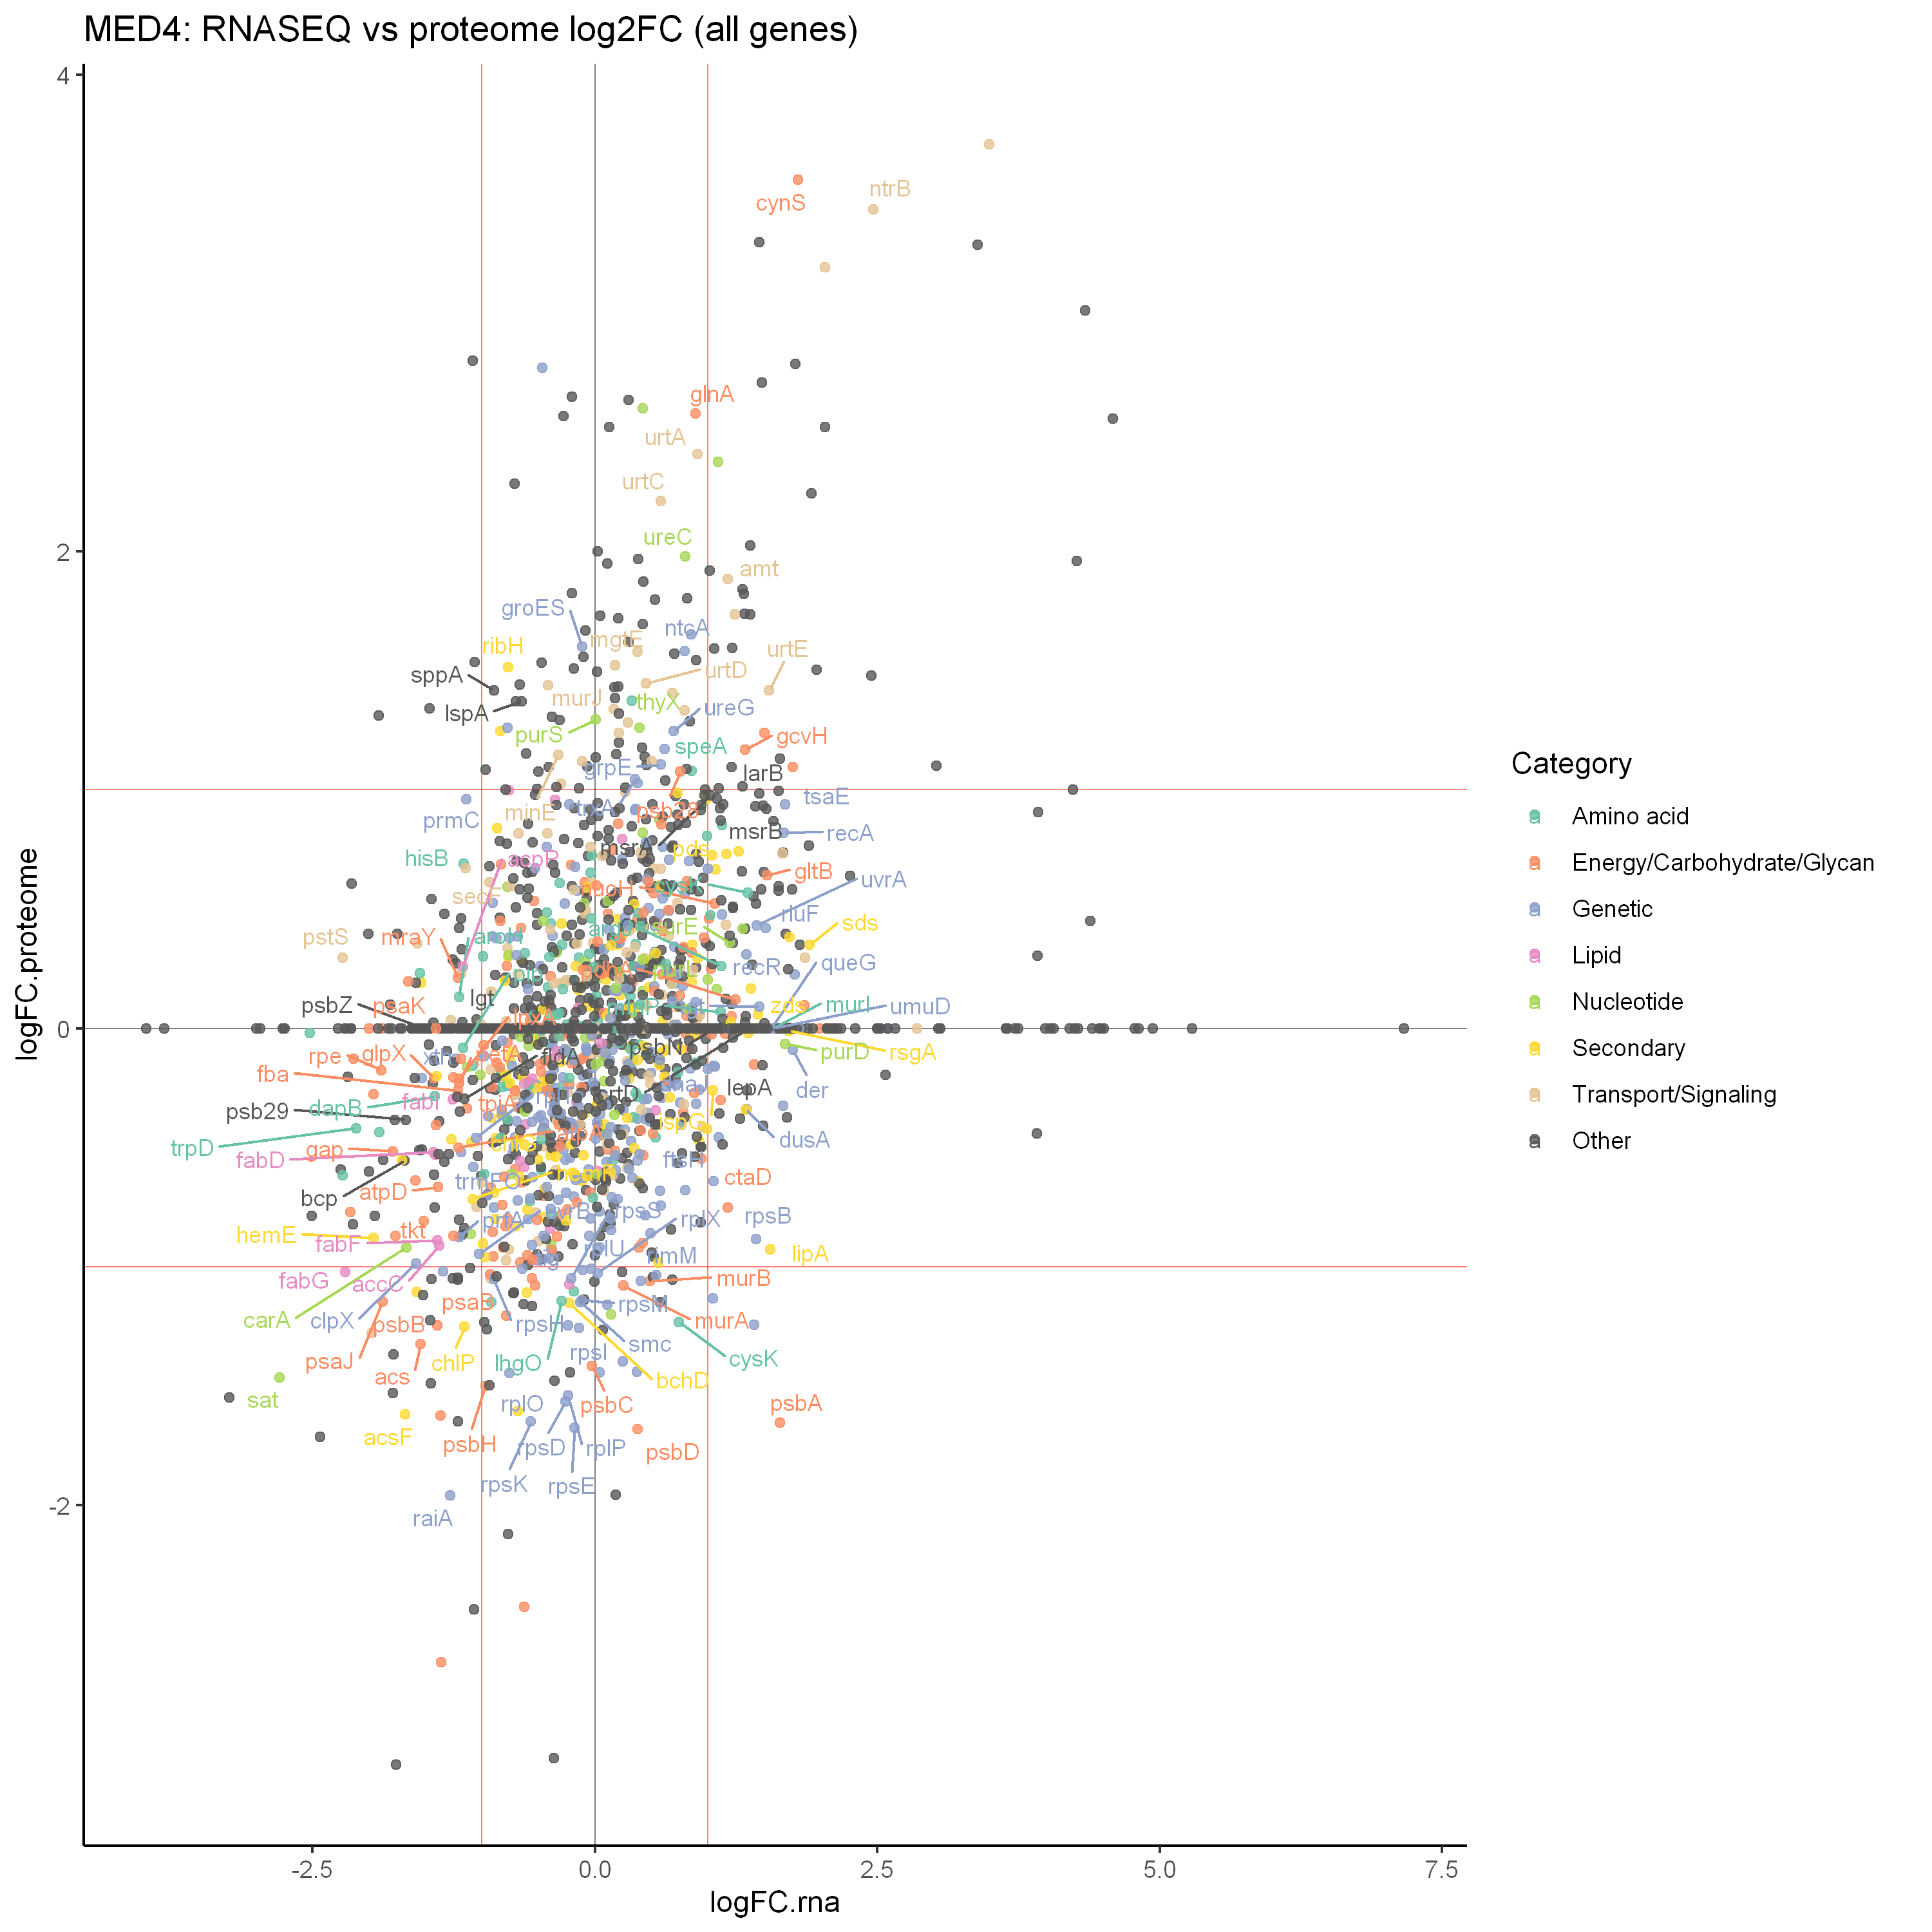

In [24]:
ggplot(lc_df, aes(x=logFC.rna, y=logFC.proteome, color=Category, #, size=-log10(pvalue.proteome)
                 )) +
    geom_vline(xintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add fold change cutoffs
    geom_hline(yintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add significance cutoffs
    geom_vline(xintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
    geom_hline(yintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
   geom_point(size=1.5, alpha=0.8) + 
   geom_text_repel(data=subset(lc_df, ((abs(logFC.proteome)>1)&padj.proteome<0.1)|((abs(logFC.rna)>1)&padj.rna<0.1)),
                    aes( x=logFC.rna, y=logFC.proteome,label=gene), max.overlaps = Inf, size=3) + # add gene label
    scale_color_manual(values=my.cols) +
    ggtitle('MED4: RNASEQ vs proteome log2FC (all genes)') +
#scale_colour_brewer(palette = "Set1") +
    theme_classic()

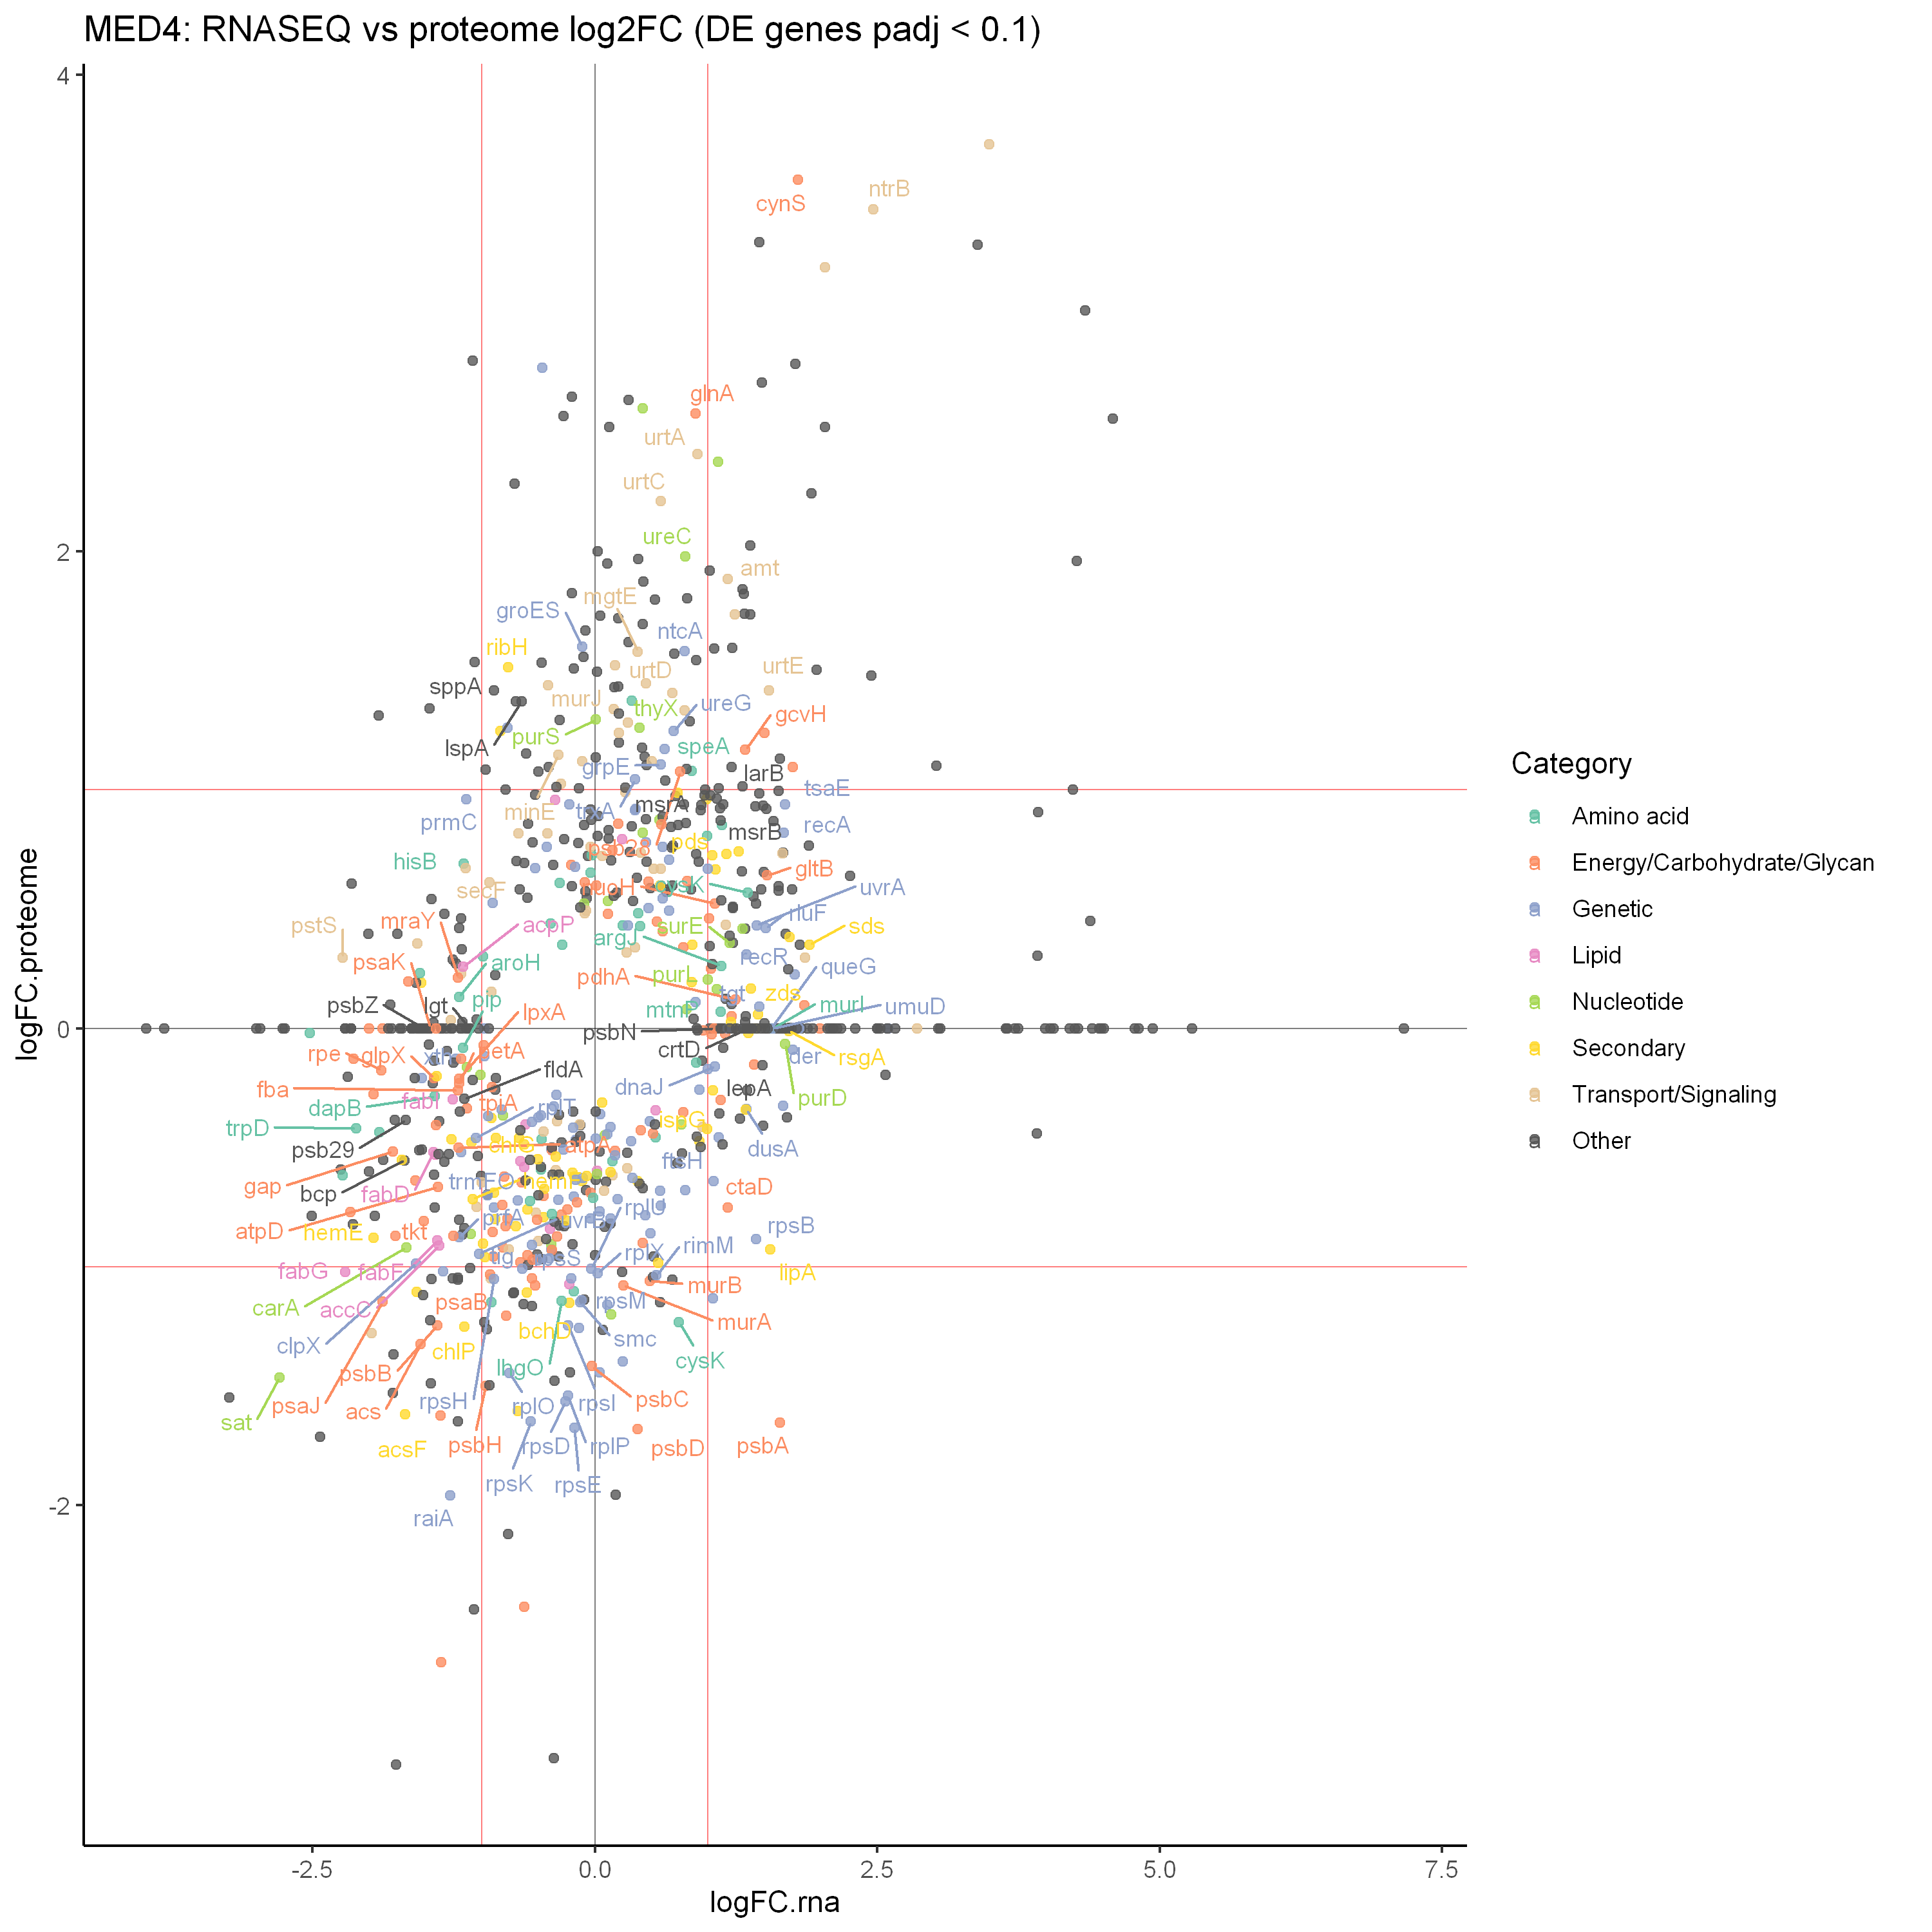

In [25]:
ggplot(subset(lc_df, (padj.proteome<0.1)|(padj.rna<0.1)), 
       aes(x=logFC.rna, y=logFC.proteome, color=Category, #, size=-log10(pvalue.proteome)
                 )) +
    geom_vline(xintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add fold change cutoffs
    geom_hline(yintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add significance cutoffs
    geom_vline(xintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
    geom_hline(yintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
   geom_point(size=1.5, alpha=0.8) + 
   geom_text_repel(data=subset(lc_df, ((abs(logFC.proteome)>1)&padj.proteome<0.1)|((abs(logFC.rna)>1)&padj.rna<0.1)),
                    aes( x=logFC.rna, y=logFC.proteome,label=gene), max.overlaps = Inf, size=3) + # add gene label
    scale_color_manual(values=my.cols) +
    ggtitle('MED4: RNASEQ vs proteome log2FC (DE genes padj < 0.1)') +

#scale_colour_brewer(palette = "Set1") +
    theme_classic()

# upset plots

In [62]:
set_size = function(w, h, factor=1.5) {
    s = 1 * factor
    options(
        repr.plot.width=w * s,
        repr.plot.height=h * s,
        repr.plot.res=100 / factor,
        jupyter.plot_mimetypes='image/png',
        jupyter.plot_scale=1
    )
}

In [63]:
df_DElist_prot1 = df_prot1 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval')
df_DElist_prot2 = df_prot2 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval')


In [64]:
df_DElist_rna1 = df_rnaseq1 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') 
df_DElist_rna2 = df_rnaseq2 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') 
    


In [65]:
df_DElist = bind_rows(df_DElist_prot1, df_DElist_prot2, df_DElist_rna1, df_DElist_rna2)

In [66]:
lookup <- c(
    "C2 - C1" = 'C2vsC1_prot', 
    "C3 - C1" = 'C3vsC1_prot', 
    "C4 - C1" = 'C4vsC1_prot', 
    "C5 - C1" = 'C5vsC1_prot', 
    "Clongterm - C1" = 'LATEvsC1_prot', 
    "P2 - P1" = 'P2vsP1_prot',
    "P3 - P1" = 'P3vsP1_prot',
    "P5 - P1" = 'P5vsP1_prot',
    "Intercept" = "Intercept",
    "treatment_long.term_vs_ref" = 'LATEvsC1P1_rna', 
    "groupandtime_P2_vs_P1" = 'P2vsP1_rna', 
    "groupandtime_C1_vs_P1" = 'C1vsP1_rna', 
    "groupandtime_C2_vs_P1" = 'C2vsP1_rna', 
    "groupandtime_C3_vs_P1" = 'C3vsP1_rna', 
    "groupandtime_C4_vs_P1" = 'C4vsP1_rna', 
    "groupandtime_C5_vs_P1" = 'C5vsP1_rna')
    
    
df_DElist = df_DElist %>% 
    mutate(contrast1 = lookup[contrast]) %>%
    filter(contrast != 'Intercept')

In [67]:
df_DElist = left_join(df_DElist, hpath_df_to_export, by='gene_id')


In [68]:
df_DElist = df_DElist %>% 
    mutate(Category = case_when(
           grepl('09103 Lipid metabolism', sub)~'Lipid',
           grepl('09131 Membrane transport', sub)~'Transport/Signaling',
           grepl('09104 Nucleotide metabolism', sub)~'Nucleotide',
           grepl('09101 Carbohydrate metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09105 Amino acid metabolism', sub)~'Amino acid',
           grepl('09106 Metabolism of other amino acids', sub)~'Amino acid',
            
           grepl('09108 Metabolism of cofactors and vitamins', sub)~'Secondary',
           grepl('09107 Glycan biosynthesis and metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09109 Metabolism of terpenoids and polyketides', sub)~'Secondary',

           grepl('09183 Protein families: signaling and cellular processes', sub)~'Transport/Signaling',
           grepl('09193 Unclassified: signaling and cellular processes', sub)~'Transport/Signaling',
        
           grepl('09182 Protein families: genetic information processing', sub)~'Genetic',
           grepl('09192 Unclassified: genetic information processing', sub)~'Genetic',
        
           grepl('09102 Energy metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09124 Replication and repair', sub)~'Replication',
        
            TRUE~'Other'
           )) 

In [69]:
df_DElist$Category = factor(df_DElist$Category, levels = c("Amino acid", "Energy/Carbohydrate/Glycan", 
"Genetic", "Lipid", "Nucleotide",  "Secondary", "Transport/Signaling", "Other"))
my.cols <- c(brewer.pal(7, "Set2"), 'grey34')


In [70]:
contrast_list = unique(df_DElist$contrast1)


In [71]:
dput(contrast_list)

c("C2vsC1_prot", "C3vsC1_prot", "C4vsC1_prot", "C5vsC1_prot", 
"LATEvsC1_prot", "P2vsP1_prot", "P3vsP1_prot", "P5vsP1_prot", 
"LATEvsC1P1_rna", "P2vsP1_rna", "C1vsP1_rna", "C2vsP1_rna", "C3vsP1_rna", 
"C4vsP1_rna", "C5vsP1_rna")


In [72]:
rna_CC_list = c(#"C1vsP1_rna", 
                "C2vsP1_rna", "C3vsP1_rna", "C4vsP1_rna", "C5vsP1_rna")
prot_CC_list = c("C2vsC1_prot", "C3vsC1_prot", "C4vsC1_prot", "C5vsC1_prot")
latelist = c("LATEvsC1_prot","LATEvsC1P1_rna")


c("C2vsC1_prot", "C3vsC1_prot", "C4vsC1_prot", "C5vsC1_prot", 
"LATEvsC1_prot", "P2vsP1_prot", "P3vsP1_prot", "P5vsP1_prot", 
"LATEvsC1P1_rna", "P2vsP1_rna", "C1vsP1_rna", "C2vsP1_rna", "C3vsP1_rna", 
"C4vsP1_rna", "C5vsP1_rna")

[1] "C2vsC1_prot"    "C3vsC1_prot"    "C4vsC1_prot"    "C5vsC1_prot"   
 [5] "LATEvsC1_prot"  "P2vsP1_prot"    "P3vsP1_prot"    "P5vsP1_prot"   
 [9] "LATEvsC1P1_rna" "P2vsP1_rna"     "C1vsP1_rna"     "C2vsP1_rna"    
[13] "C3vsP1_rna"     "C4vsP1_rna"     "C5vsP1_rna"

In [73]:
head(df_DElist)

,contrast,gene_id,logFC,AveExpr,pvalue,padj,contrast1,gene,product,protein_id,old_locus_tag,X,path_id,main,sub,path,ecpath,Category
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
1,C2 - C1,TX50_RS01980,2.6029332,0.9167156,5.951467e-07,0.0004868287,C2vsC1_prot,,ABC transporter ATP-binding protein,WP_011132009.1,NA,549,K15578,09100 Metabolism;09130 Environmental Information Processing;09180 Brite Hierarchies,09102 Energy metabolism;09131 Membrane transport;09183 Protein families: signaling and cellular processes,00910 Nitrogen metabolism [PATH:ko00910];02010 ABC transporters [PATH:ko02010];02000 Transporters [BR:ko02000],"K15578 nrtC, nasD; nitrate/nitrite transport system ATP-binding protein [EC:7.3.2.4]",Transport/Signaling
2,C2 - C1,TX50_RS05125,1.7956460,2.0464881,8.763244e-07,0.0004868287,C2vsC1_prot,ureC,urease subunit alpha,WP_011132596.1,NA,1437,K01428,09100 Metabolism;09160 Human Diseases,09104 Nucleotide metabolism;09105 Amino acid metabolism;09111 Xenobiotics biodegradation and metabolism;09171 Infectious disease: bacterial,00230 Purine metabolism [PATH:ko00230];00220 Arginine biosynthesis [PATH:ko00220];00791 Atrazine degradation [PATH:ko00791];05120 Epithelial cell signaling in Helicobacter pylori infection [PATH:ko05120],K01428 ureC; urease subunit alpha [EC:3.5.1.5],Nucleotide
3,C2 - C1,TX50_RS09075,1.1167539,1.4678595,1.025622e-06,0.0004868287,C2vsC1_prot,acnB,bifunctional aconitate hydratase 2/2-methylisocitrate dehydratase,WP_011133327.1,NA,2496,K01682,09100 Metabolism,09101 Carbohydrate metabolism;09102 Energy metabolism,00020 Citrate cycle (TCA cycle) [PATH:ko00020];00630 Glyoxylate and dicarboxylate metabolism [PATH:ko00630];00640 Propanoate metabolism [PATH:ko00640];00720 Carbon fixation pathways in prokaryotes [PATH:ko00720],K01682 acnB; aconitate hydratase 2 / 2-methylisocitrate dehydratase [EC:4.2.1.3 4.2.1.99],Energy/Carbohydrate/Glycan
4,C2 - C1,TX50_RS05175,1.4380690,-0.2070244,2.486196e-06,0.0008850858,C2vsC1_prot,urtD,urea ABC transporter ATP-binding protein UrtD,WP_011132606.1,NA,1455,K11962,09130 Environmental Information Processing;09180 Brite Hierarchies,09131 Membrane transport;09183 Protein families: signaling and cellular processes,02010 ABC transporters [PATH:ko02010];02000 Transporters [BR:ko02000],K11962 urtD; urea transport system ATP-binding protein,Transport/Signaling
5,C2 - C1,TX50_RS08845,-0.9884268,3.7497430,3.186503e-06,0.0009075161,C2vsC1_prot,tig,trigger factor,WP_011133282.1,NA,2421,K03545,09190 Not Included in Pathway or Brite,09192 Unclassified: genetic information processing,99975 Protein processing,K03545 tig; trigger factor,Genetic
6,C2 - C1,TX50_RS01985,1.7087460,-0.2557767,5.226353e-06,0.0012403878,C2vsC1_prot,cynS,cyanase,WP_011132010.1,NA,552,K01725,09100 Metabolism,09102 Energy metabolism,00910 Nitrogen metabolism [PATH:ko00910],K01725 cynS; cyanate lyase [EC:4.2.1.104],Energy/Carbohydrate/Glycan


Warning message in upset_data(data, intersect, mode = mode, encode_sets = encode_sets, :
"Converting non-logical columns to binary: C2vsP1_rna, C3vsP1_rna, C4vsP1_rna, C5vsP1_rna, C2vsC1_prot, C3vsC1_prot, C4vsC1_prot, C5vsC1_prot"


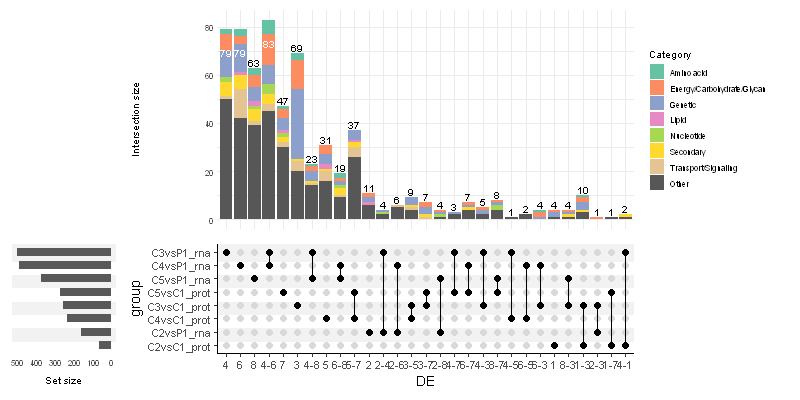

In [81]:
set_size(8,4 )
df_DElist %>%
    filter(padj < 0.1, abs(logFC) > 1, contrast != 'Intercept') %>%
    pivot_wider(id_cols = c(gene_id,Category), names_from = contrast1, values_from = logFC, values_fill = FALSE) %>% 
upset(c(rna_CC_list, prot_CC_list), name='DE', 
    base_annotations=list(
        'Intersection size'=intersection_size(
            mapping=aes(fill=Category)
        )
            + scale_fill_manual(values=my.cols)
    ),      
#     annotations = list(
#         'Categories'=(
#             ggplot(mapping=aes(fill=Category))
#             + geom_bar(stat='count', position='fill')
#             + scale_y_continuous(labels=scales::percent_format())
#             + scale_fill_manual(values=my.cols
#             )
#             + ylab('Category')
#         )
#     ),
      width_ratio=0.2, 
      #min_size=10, 
      mode='inclusive_intersection',
      min_degree=1, max_degree=2) +
theme_classic(base_size = 15)

Warning message in upset_data(data, intersect, mode = mode, encode_sets = encode_sets, :
"Converting non-logical columns to binary: C1vsP1_rna, C2vsP1_rna, C3vsP1_rna, C4vsP1_rna, C5vsP1_rna, C2vsC1_prot, C3vsC1_prot, C4vsC1_prot, C5vsC1_prot"


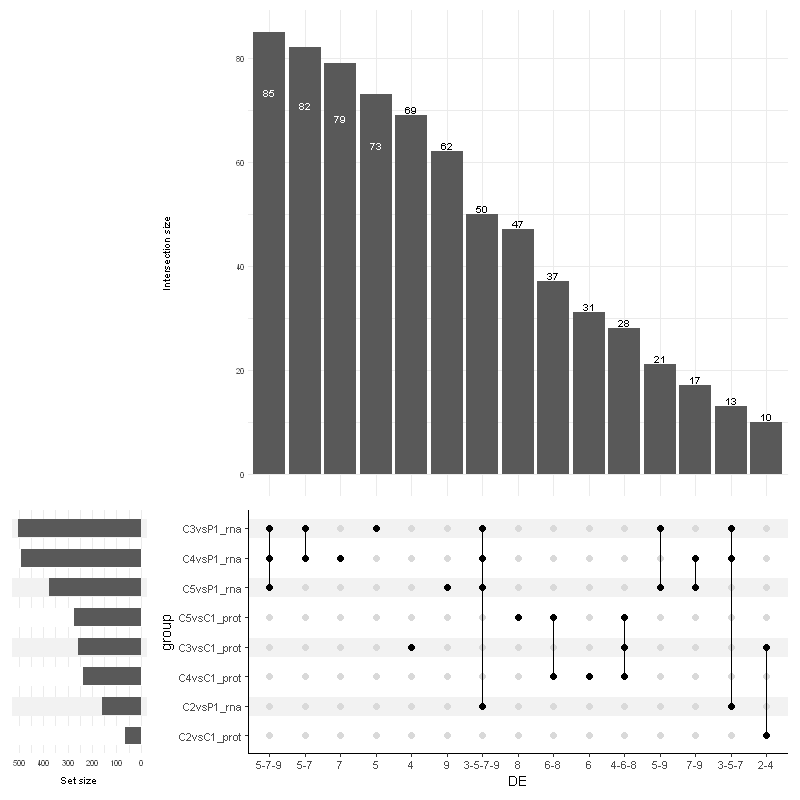

In [49]:
set_size(8,8 )
df_DElist %>%
    filter(padj < 0.1, abs(logFC) > 1, contrast != 'Intercept') %>%
    pivot_wider(id_cols = gene_id, names_from = contrast1, values_from = logFC, values_fill = FALSE) %>% 
upset(c(rna_CC_list, prot_CC_list), name='DE', width_ratio=0.2, 
      min_size=10, min_degree=1) +
theme_classic(base_size = 15)

In [34]:
df_DElist %>%
    filter(padj < 0.1, abs(logFC) > 1) %>%
    dplyr::group_by(gene_id, contrast1) %>%
    dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
    dplyr::filter(n > 1L)

gene_id,contrast1,n
<chr>,<chr>,<int>


In [37]:
sessionInfo()

R version 4.2.0 (2022-04-22 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19044)

Matrix products: default

locale:
[1] LC_COLLATE=English_Israel.utf8  LC_CTYPE=English_Israel.utf8   
[3] LC_MONETARY=English_Israel.utf8 LC_NUMERIC=C                   
[5] LC_TIME=English_Israel.utf8    

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.9.1               ComplexUpset_1.3.3         
 [3] corrplot_0.92               pheatmap_1.0.12            
 [5] lubridate_1.9.2             forcats_1.0.0              
 [7] stringr_1.5.0               dplyr_1.1.0                
 [9] purrr_1.0.1                 readr_2.1.4                
[11] tidyr_1.3.0                 tibble_3.1.8               
[13] tidyverse_2.0.0             readxl_1.4.2               
[15] goseq_1.50.0                geneLenDataBase_1.34.0     
[17] BiasedUrn_2.0.8             GGally_2.1.2 